In [234]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [235]:
def read_csv(file):
    #čitanje csva
    df = pd.read_csv(file,usecols=['id','time'], parse_dates=['time'], encoding='latin1')
    #print(df)
    return df

In [266]:
def get_limits(month, year):
    if month!=12:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year,month+1))-pd.Timedelta(days=1)
    else:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year+1,1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("{}-{}-01 00:00:00".format(year,month))
    #print(end,beginning)
    return end, beginning

In [237]:
def calculate_diff(df, column, beginning, end):
    #oduzimanje susjednih redaka
    df['diff']=df[column].diff(periods=1)    
     #izračun razmaka između poč. mjeseca i prvog mjerenja
    df.loc[0,'diff']=df.loc[0, column] - beginning
    #izračun razmaka između kraja mjeseca i zadnjeg mjerenja
    df.loc[len(df)] = {'diff':end - df.loc[len(df)-1, column], column: end}

In [238]:
def filter_rows(step,df):
    df['index'] = range(len(df))
    df2=df[df['diff'] > step]
    #filtiranje samo redaka čiji je diff veci od odabranog step-a (i njihovih prethodnika)
    previous_row = df2['index'] - 1
    result = pd.concat([df[df['index'].isin(previous_row) ], df2])
    result.sort_index(inplace=True, ignore_index=True)
    #print(result)
    return result

In [239]:
def make_table(result, beginning,step):
    #print(result)
    if result.loc[0,'index']==0 and result.loc[0,'diff']>step:
        #prvi red ima rupu od poč. mjeseca tj prvi snimljeni trenutak je upao u trenutke s rupom
        new_df=pd.DataFrame({'start-time':[beginning], 'end-time':[result.loc[0,'time']], 'duration':[result.loc[0,'diff']]})
        #print(new_df)
        new_df=pd.concat([new_df,pd.DataFrame({
        'start-time': result['time'].iloc[1::2].reset_index(drop=True),
        'end-time': result['time'].iloc[2::2].reset_index(drop=True),
        'duration': result['diff'].iloc[2::2].reset_index(drop=True)
        })], ignore_index=True)
        #print(new_df)
    else:
        #nema rupe od poč. mjeseca, uzimam parove redaka
        new_df = pd.DataFrame({
            'start-time': result['time'].iloc[0::2].reset_index(drop=True),
            'end-time': result['time'].iloc[1::2].reset_index(drop=True),
            'duration': result['diff'].iloc[1::2].reset_index(drop=True)
        })
    return new_df

In [240]:
def obrada(month, year, step):
    #step definira koja je granica za rupu
    df = read_csv("bojler\{}\{}_{}.csv".format(year,month,year))
    end, beginning = get_limits(month, year)
    #nijedan podatak nije zabiljezen u mjesecu
    if df.empty:
        df=pd.DataFrame({'start-time':[beginning], 'end-time':[end], 'duration':[end-beginning]})
        return df
    #izračun rupa između mjerenja
    calculate_diff(df,'time', beginning, end)
    #print(df)
    #filtriranje rupa vecih od stepa
    result = filter_rows(step,df)
    if(result.empty):
        print("nema rupa")
        return result
    #formiranje tablice u obliku start - end - duration
    final_result = make_table(result, beginning,step)
    print(final_result)
    return final_result

end=pd.to_datetime("2022-{}-01 23:59:59".format(month+1))-pd.Timedelta(days=1)
beginning=pd.to_datetime("2022-{}-01 00:00:00".format(month))
all_timestamps = pd.date_range(start=beginning, end=end, freq='120S')


is_within_interval_list = [
    any((timestamp >= row['time1']) and (timestamp <= row['time2']) for i, row in df.iterrows())
    for timestamp in all_timestamps
]

plt.plot(all_timestamps, is_within_interval_list)
tick_positions = pd.date_range(start=beginning, end=end, freq='1D')
plt.xticks(tick_positions, [timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)  

plt.xlabel('Timestamp', fontsize=10) 
plt.ylabel('Is within interval (1 or 0)')
plt.title('Scatter Plots of Timestamps within Intervals for the Entire Month')

fig = plt.gcf()
fig.set_size_inches(20, 6)  # Adjust the width and height as needed
plt.savefig('responsive_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [241]:
def generate_all_timestamps(beginning, end, frequency):
    all_timestamps = pd.date_range(start=beginning, end=end, freq=frequency)
    return all_timestamps

In [242]:
def check_holes(all_timestamps, df):
    is_within_interval_list = [
        any((timestamp >= row['start-time']) and (timestamp <= row['end-time']) for i, row in df.iterrows())
        for timestamp in all_timestamps
    ]
    return is_within_interval_list
    

In [243]:
def check_holes_better(all_timestamps, df):
    is_within_interval_list = []
    i = 0
    for index, row in df.iterrows():
        while i < len(all_timestamps) and all_timestamps[i] < row['start-time']:
            is_within_interval_list.append(False)
            i += 1
        while i < len(all_timestamps) and all_timestamps[i] >= row['start-time'] and all_timestamps[i] <= row['end-time']:
            is_within_interval_list.append(True)
            i += 1
    while i < len(all_timestamps):
        is_within_interval_list.append(False)
        i += 1
    return is_within_interval_list

In [251]:
def create_graph(ax, all_timestamps, beginning, end, month, interval_list,step,pctg):
    
    ax.plot(all_timestamps, interval_list, linewidth=0.5)
    tick_positions = pd.date_range(start=beginning, end=end, freq='2D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
    
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('1 - rupa, 0 - zapis')
    ax.set_title("rupa:{}s, postotak:{}%".format(int(step.total_seconds()), round(pctg,2)))
    
    #fig.set_size_inches(20, 6)  # Adjust the width and height as needed
    #plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    return


In [259]:
def make_graph(month,year, steps, save):
    print("{}. mjesec".format(month))
    end, beginning = get_limits(month, year)
    #generiranje svih 'trenutaka' u mjesecu kad bi podaci trebali biti upisani
    all_timestamps = generate_all_timestamps(beginning, end, '3S')
    #stvaranje novog prozora za novi mjesec
    fig, ax = plt.subplots(nrows=1, ncols=len(steps), figsize=(20, 5))
    fig.suptitle("{}. mjesec {}.".format(month,year))
    k=0
    for step in steps:
        df=obrada(month,year,step)
        #true za trenutke koji su u rupi, false za one koji nisu
        interval_list = check_holes_better(all_timestamps, df)
        percentage = interval_list.count(True)/len(interval_list)*100
        print("Postotak rupa: {} %, rupa: {}".format(round(percentage,2),step))
        #stvaranje grafa
        if len(steps)==1:
            create_graph(ax, all_timestamps, beginning, end, month, interval_list, step, percentage)
        else:   
            create_graph(ax[k], all_timestamps, beginning, end, month, interval_list, step, percentage)
        k+=1
    #plt.title("{}. mjesec".format(month))
    if save:
        plt.savefig("{}_{}_graph.png".format(month,year), dpi=600, bbox_inches='tight')
    plt.show() 
    return



11. mjesec
               start-time            end-time        duration
0     2023-11-01 00:00:03 2023-11-01 00:00:06 0 days 00:00:03
1     2023-11-01 00:00:30 2023-11-01 00:00:33 0 days 00:00:03
2     2023-11-01 00:00:55 2023-11-01 00:00:58 0 days 00:00:03
3     2023-11-01 00:01:20 2023-11-01 00:01:23 0 days 00:00:03
4     2023-11-01 00:01:43 2023-11-01 00:01:46 0 days 00:00:03
...                   ...                 ...             ...
90344 2023-11-29 23:58:19 2023-11-29 23:58:22 0 days 00:00:03
90345 2023-11-29 23:58:44 2023-11-29 23:58:47 0 days 00:00:03
90346 2023-11-29 23:59:11 2023-11-29 23:59:14 0 days 00:00:03
90347 2023-11-29 23:59:38 2023-11-29 23:59:41 0 days 00:00:03
90348 2023-11-29 23:59:59 2023-11-30 23:59:59 1 days 00:00:00

[90349 rows x 3 columns]
Postotak rupa: 26.3 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-11-02 12:26:45 2023-11-02 12:26:49 0 days 00:00:04
1  2023-11-09 17:22:56 2023-11-09 17:23:00 0 days 00:00:

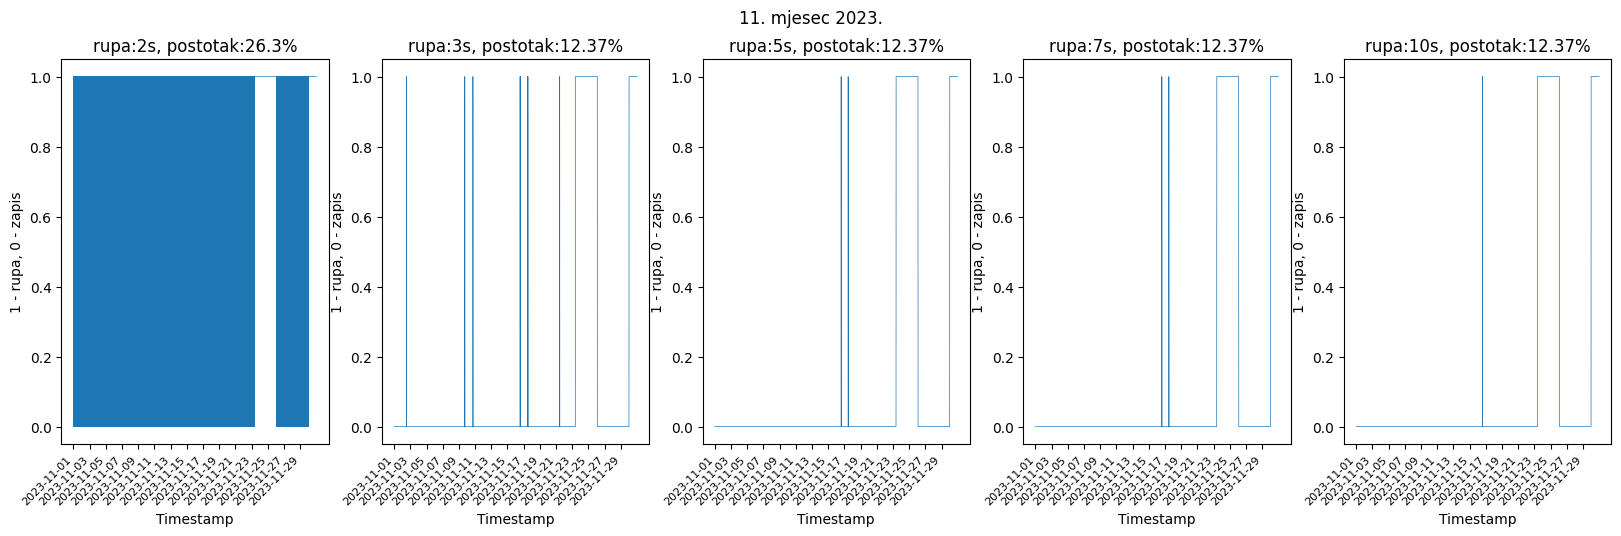

In [268]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05'),pd.to_timedelta('00:00:07'),pd.to_timedelta('00:00:10')]

make_graph(11,2023,steps, True)
#for i in range(4,12):
 #  make_graph(i, step)

5. mjesec
               start-time            end-time        duration
0     2022-05-01 00:00:44 2022-05-01 00:00:47 0 days 00:00:03
1     2022-05-01 00:01:43 2022-05-01 00:01:46 0 days 00:00:03
2     2022-05-01 00:02:52 2022-05-01 00:02:55 0 days 00:00:03
3     2022-05-01 00:03:31 2022-05-01 00:03:34 0 days 00:00:03
4     2022-05-01 00:04:04 2022-05-01 00:04:07 0 days 00:00:03
...                   ...                 ...             ...
31449 2022-05-27 05:04:56 2022-05-27 05:04:59 0 days 00:00:03
31450 2022-05-27 05:06:19 2022-05-27 05:06:22 0 days 00:00:03
31451 2022-05-27 05:07:28 2022-05-27 05:07:31 0 days 00:00:03
31452 2022-05-27 05:08:27 2022-05-27 05:08:30 0 days 00:00:03
31453 2022-05-27 05:08:36 2022-05-31 23:59:59 4 days 18:51:23

[31454 rows x 3 columns]
Postotak rupa: 24.95 %, rupa: 0 days 00:00:02


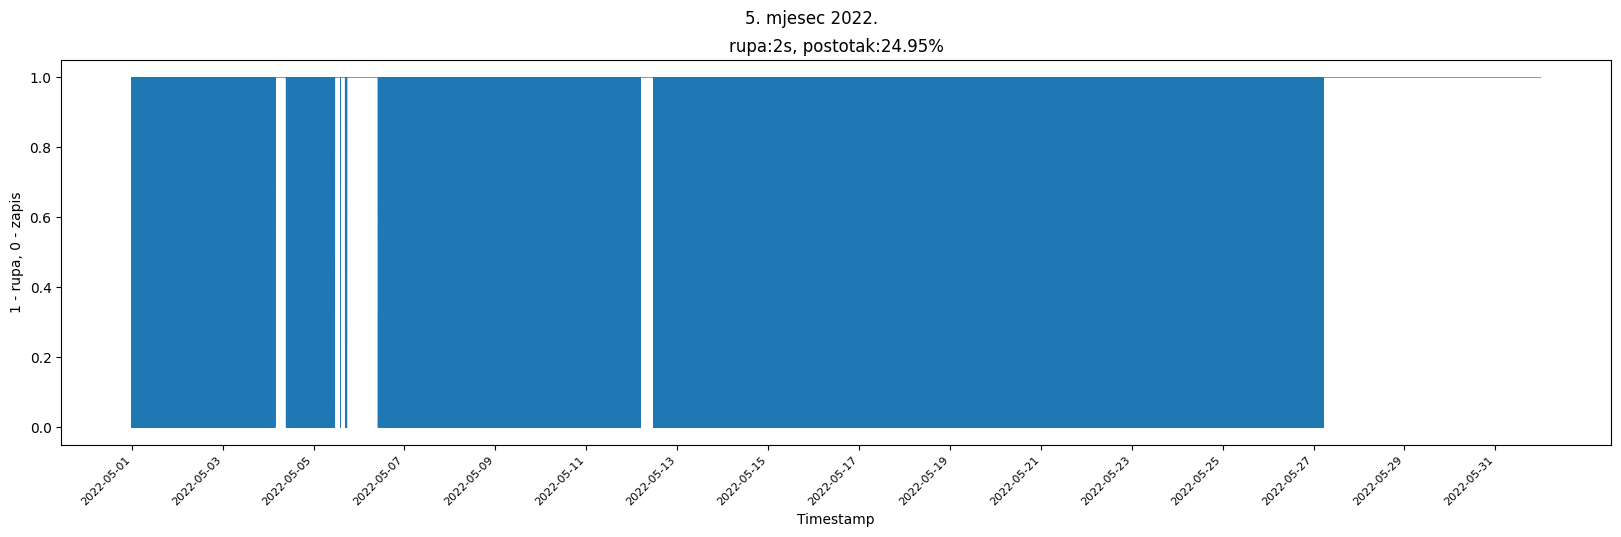

In [260]:
make_graph(12,2022,[pd.to_timedelta('00:00:02')], True)

4. mjesec
               start-time            end-time        duration
0     2022-04-01 00:00:00 2022-04-07 14:13:36 6 days 14:13:36
1     2022-04-07 14:13:36 2022-04-07 14:13:41 0 days 00:00:05
2     2022-04-07 14:13:41 2022-04-07 14:13:46 0 days 00:00:05
3     2022-04-07 14:13:46 2022-04-07 14:13:51 0 days 00:00:05
4     2022-04-07 14:13:51 2022-04-07 14:13:56 0 days 00:00:05
...                   ...                 ...             ...
86051 2022-04-29 23:57:03 2022-04-29 23:57:06 0 days 00:00:03
86052 2022-04-29 23:57:52 2022-04-29 23:57:55 0 days 00:00:03
86053 2022-04-29 23:58:33 2022-04-29 23:58:36 0 days 00:00:03
86054 2022-04-29 23:59:06 2022-04-29 23:59:09 0 days 00:00:03
86055 2022-04-29 23:59:59 2022-04-30 23:59:59 1 days 00:00:00

[86056 rows x 3 columns]
Postotak rupa: 52.2 %, rupa: 0 days 00:00:02
               start-time            end-time        duration
0     2022-04-01 00:00:00 2022-04-07 14:13:36 6 days 14:13:36
1     2022-04-07 14:13:36 2022-04-07 14:13:41 0 day

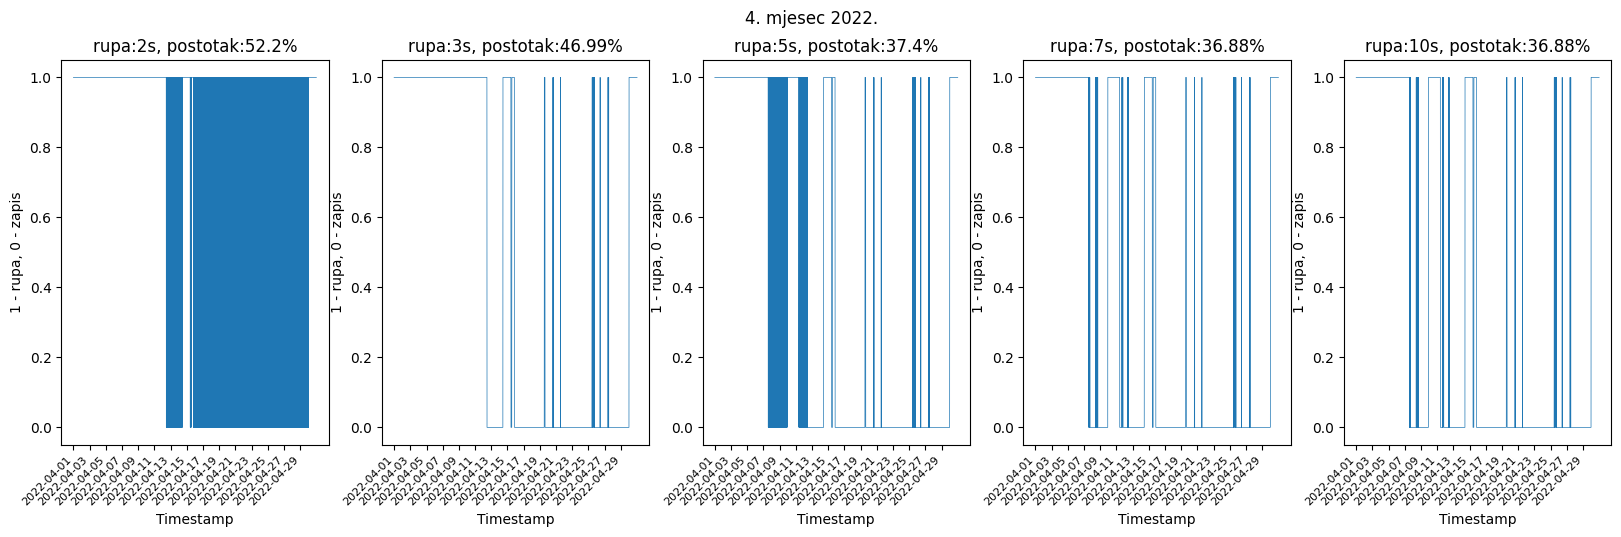

5. mjesec
               start-time            end-time        duration
0     2022-05-01 00:00:44 2022-05-01 00:00:47 0 days 00:00:03
1     2022-05-01 00:01:43 2022-05-01 00:01:46 0 days 00:00:03
2     2022-05-01 00:02:52 2022-05-01 00:02:55 0 days 00:00:03
3     2022-05-01 00:03:31 2022-05-01 00:03:34 0 days 00:00:03
4     2022-05-01 00:04:04 2022-05-01 00:04:07 0 days 00:00:03
...                   ...                 ...             ...
31449 2022-05-27 05:04:56 2022-05-27 05:04:59 0 days 00:00:03
31450 2022-05-27 05:06:19 2022-05-27 05:06:22 0 days 00:00:03
31451 2022-05-27 05:07:28 2022-05-27 05:07:31 0 days 00:00:03
31452 2022-05-27 05:08:27 2022-05-27 05:08:30 0 days 00:00:03
31453 2022-05-27 05:08:36 2022-05-31 23:59:59 4 days 18:51:23

[31454 rows x 3 columns]
Postotak rupa: 24.95 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2022-05-02 16:53:42 2022-05-02 17:00:37 0 days 00:06:55
1  2022-05-02 17:01:28 2022-05-02 17:01:32 0 days 00:00:

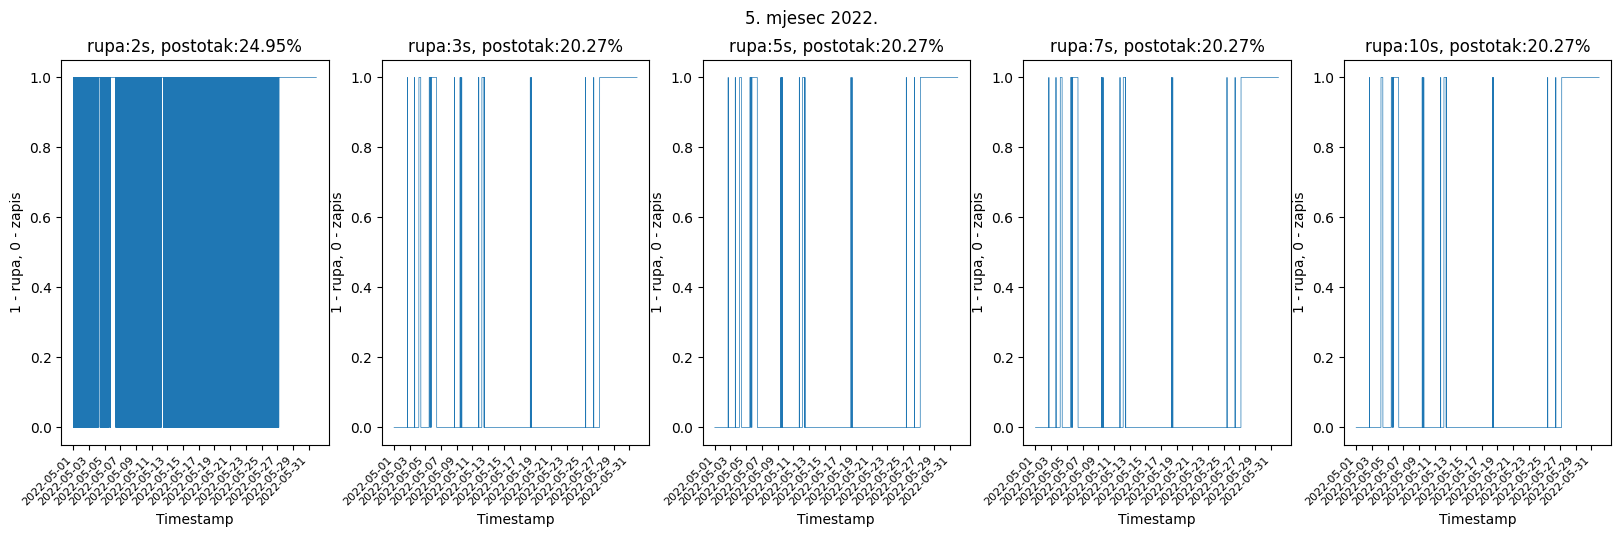

6. mjesec
               start-time            end-time        duration
0     2022-06-01 00:00:25 2022-06-01 00:00:28 0 days 00:00:03
1     2022-06-01 00:00:52 2022-06-01 00:00:55 0 days 00:00:03
2     2022-06-01 00:01:15 2022-06-01 00:01:18 0 days 00:00:03
3     2022-06-01 00:01:50 2022-06-01 00:01:53 0 days 00:00:03
4     2022-06-01 00:02:27 2022-06-01 00:02:30 0 days 00:00:03
...                   ...                 ...             ...
37487 2022-06-23 10:49:21 2022-06-23 10:49:24 0 days 00:00:03
37488 2022-06-23 10:50:02 2022-06-23 10:50:05 0 days 00:00:03
37489 2022-06-23 10:51:17 2022-06-23 10:51:20 0 days 00:00:03
37490 2022-06-23 10:52:50 2022-06-23 10:52:53 0 days 00:00:03
37491 2022-06-23 10:53:39 2022-06-30 23:59:59 7 days 13:06:20

[37492 rows x 3 columns]
Postotak rupa: 45.51 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2022-06-01 12:41:04 2022-06-01 17:33:55 0 days 04:52:51
1  2022-06-03 09:48:20 2022-06-03 09:48:58 0 days 00:00:

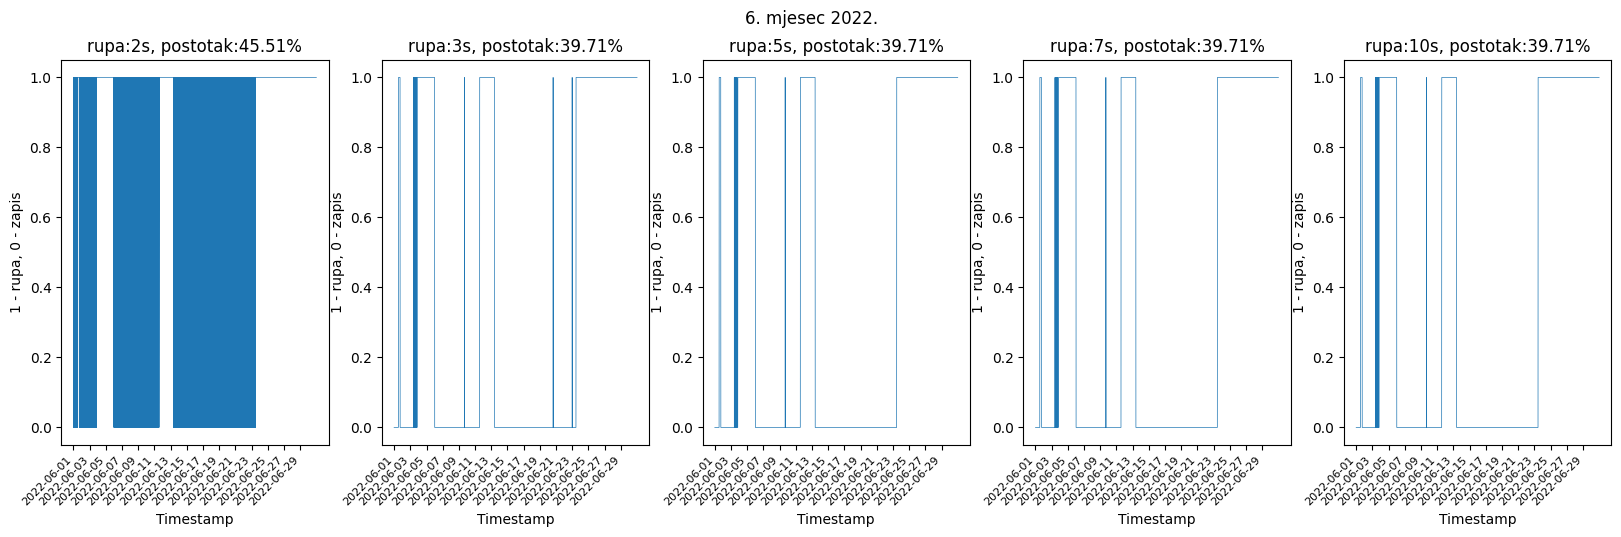

7. mjesec
               start-time            end-time         duration
0     2022-07-01 00:01:16 2022-07-01 00:01:19  0 days 00:00:03
1     2022-07-01 00:02:45 2022-07-01 00:02:48  0 days 00:00:03
2     2022-07-01 00:04:18 2022-07-01 00:04:21  0 days 00:00:03
3     2022-07-01 00:05:51 2022-07-01 00:05:54  0 days 00:00:03
4     2022-07-01 00:07:28 2022-07-01 00:07:31  0 days 00:00:03
...                   ...                 ...              ...
20758 2022-07-21 16:19:20 2022-07-21 16:19:23  0 days 00:00:03
20759 2022-07-21 16:21:07 2022-07-21 16:21:10  0 days 00:00:03
20760 2022-07-21 16:22:48 2022-07-21 16:22:51  0 days 00:00:03
20761 2022-07-21 16:24:15 2022-07-21 16:24:18  0 days 00:00:03
20762 2022-07-21 16:25:38 2022-07-31 23:59:59 10 days 07:34:21

[20763 rows x 3 columns]
Postotak rupa: 47.35 %, rupa: 0 days 00:00:02
           start-time            end-time         duration
0 2022-07-09 14:50:13 2022-07-11 07:33:29  1 days 16:43:16
1 2022-07-12 15:38:47 2022-07-14 08:33:50  1

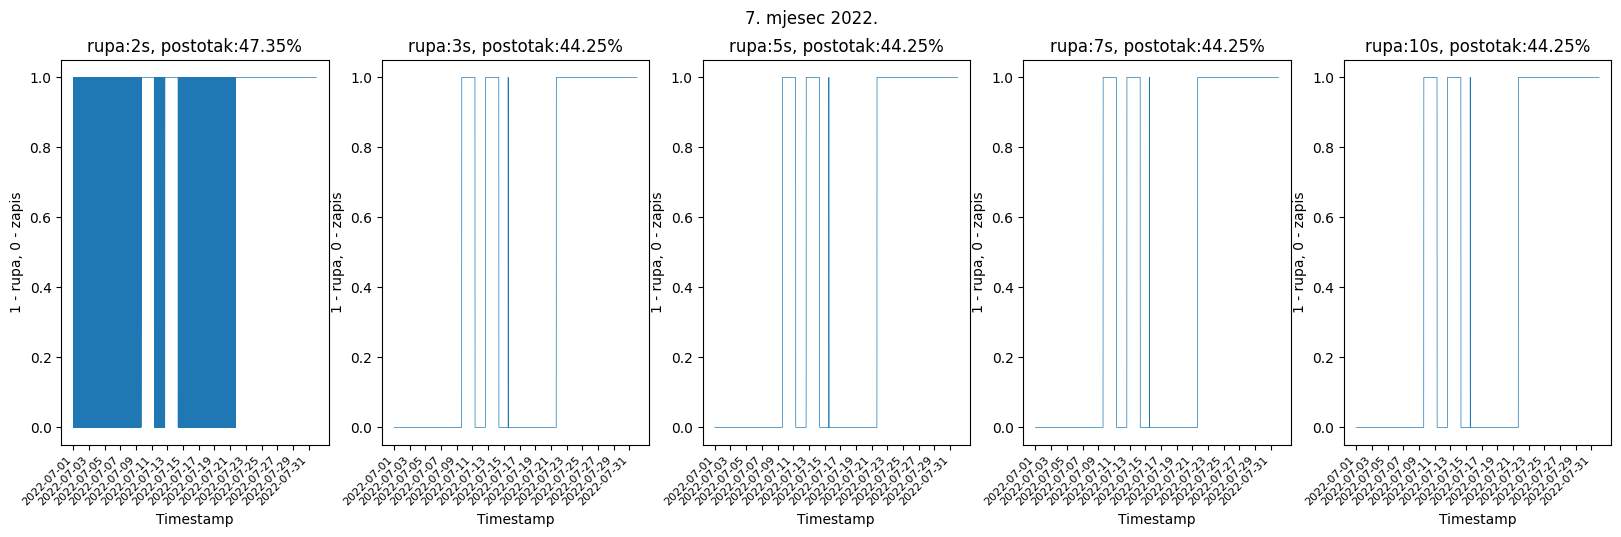

8. mjesec
Postotak rupa: 100.0 %, rupa: 0 days 00:00:02
Postotak rupa: 100.0 %, rupa: 0 days 00:00:03
Postotak rupa: 100.0 %, rupa: 0 days 00:00:05
Postotak rupa: 100.0 %, rupa: 0 days 00:00:07
Postotak rupa: 100.0 %, rupa: 0 days 00:00:10


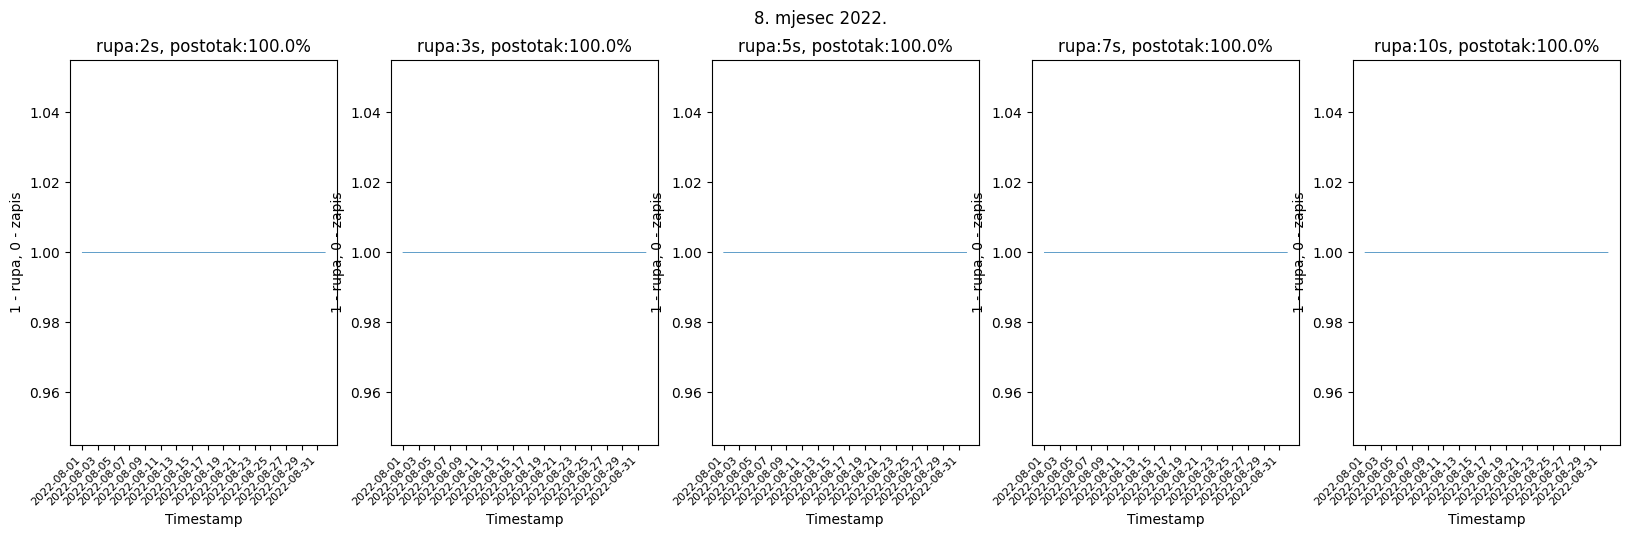

9. mjesec
               start-time            end-time         duration
0     2022-09-01 00:00:00 2022-09-08 14:31:31  7 days 14:31:31
1     2022-09-08 14:31:37 2022-09-08 14:31:40  0 days 00:00:03
2     2022-09-08 14:32:00 2022-09-08 14:32:03  0 days 00:00:03
3     2022-09-08 14:32:27 2022-09-08 14:32:30  0 days 00:00:03
4     2022-09-08 14:32:50 2022-09-08 14:32:53  0 days 00:00:03
...                   ...                 ...              ...
35145 2022-09-19 04:14:58 2022-09-19 04:15:01  0 days 00:00:03
35146 2022-09-19 04:15:29 2022-09-19 04:15:32  0 days 00:00:03
35147 2022-09-19 04:15:58 2022-09-19 04:16:01  0 days 00:00:03
35148 2022-09-19 04:16:21 2022-09-19 04:16:24  0 days 00:00:03
35149 2022-09-19 04:16:38 2022-09-30 23:59:59 11 days 19:43:21

[35150 rows x 3 columns]
Postotak rupa: 70.23 %, rupa: 0 days 00:00:02
           start-time            end-time         duration
0 2022-09-01 00:00:00 2022-09-08 14:31:31  7 days 14:31:31
1 2022-09-08 15:26:09 2022-09-08 15:50:17  0

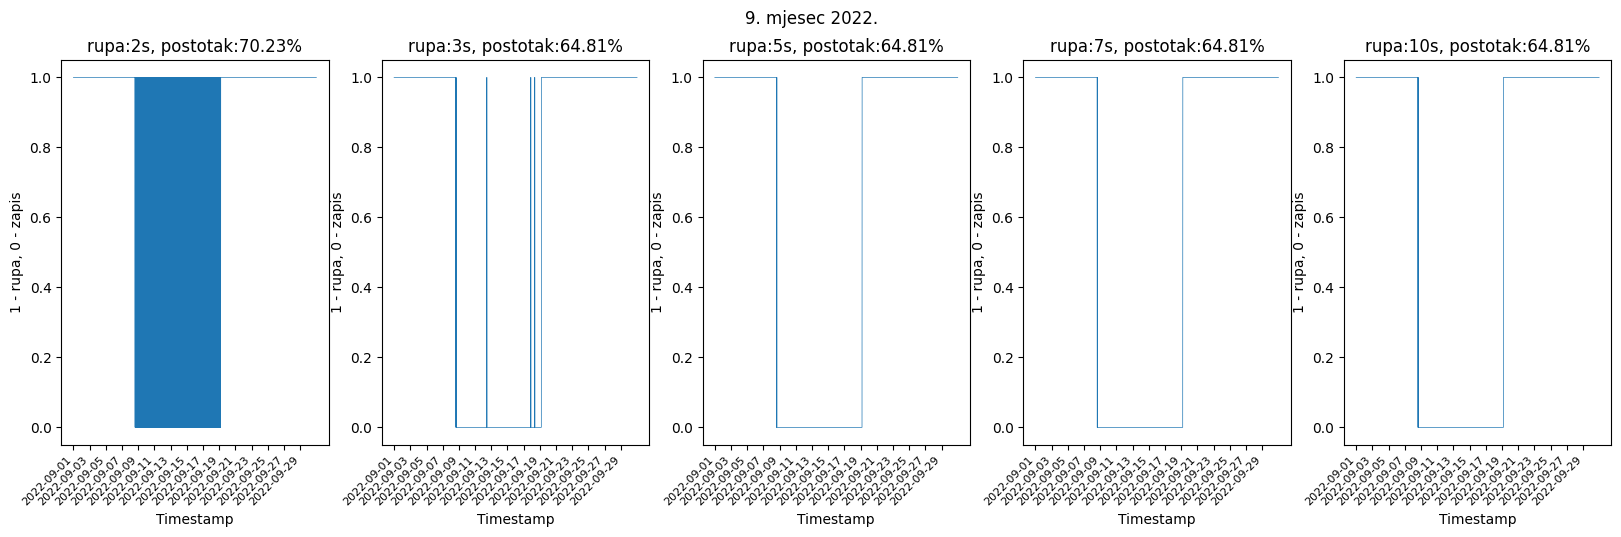

10. mjesec
              start-time            end-time        duration
0    2022-10-01 00:00:00 2022-10-04 11:08:36 3 days 11:08:36
1    2022-10-04 11:08:42 2022-10-04 11:08:45 0 days 00:00:03
2    2022-10-04 11:09:13 2022-10-04 11:09:16 0 days 00:00:03
3    2022-10-04 11:09:36 2022-10-04 11:09:39 0 days 00:00:03
4    2022-10-04 11:09:59 2022-10-04 11:10:02 0 days 00:00:03
...                  ...                 ...             ...
9681 2022-10-30 23:56:27 2022-10-30 23:56:30 0 days 00:00:03
9682 2022-10-30 23:57:30 2022-10-30 23:57:33 0 days 00:00:03
9683 2022-10-30 23:58:29 2022-10-30 23:58:32 0 days 00:00:03
9684 2022-10-30 23:59:28 2022-10-30 23:59:31 0 days 00:00:03
9685 2022-10-30 23:59:59 2022-10-31 23:59:59 1 days 00:00:00

[9686 rows x 3 columns]
Postotak rupa: 77.73 %, rupa: 0 days 00:00:02
             start-time            end-time        duration
0   2022-10-01 00:00:00 2022-10-04 11:08:36 3 days 11:08:36
1   2022-10-04 11:24:36 2022-10-04 11:29:19 0 days 00:04:43
2   20

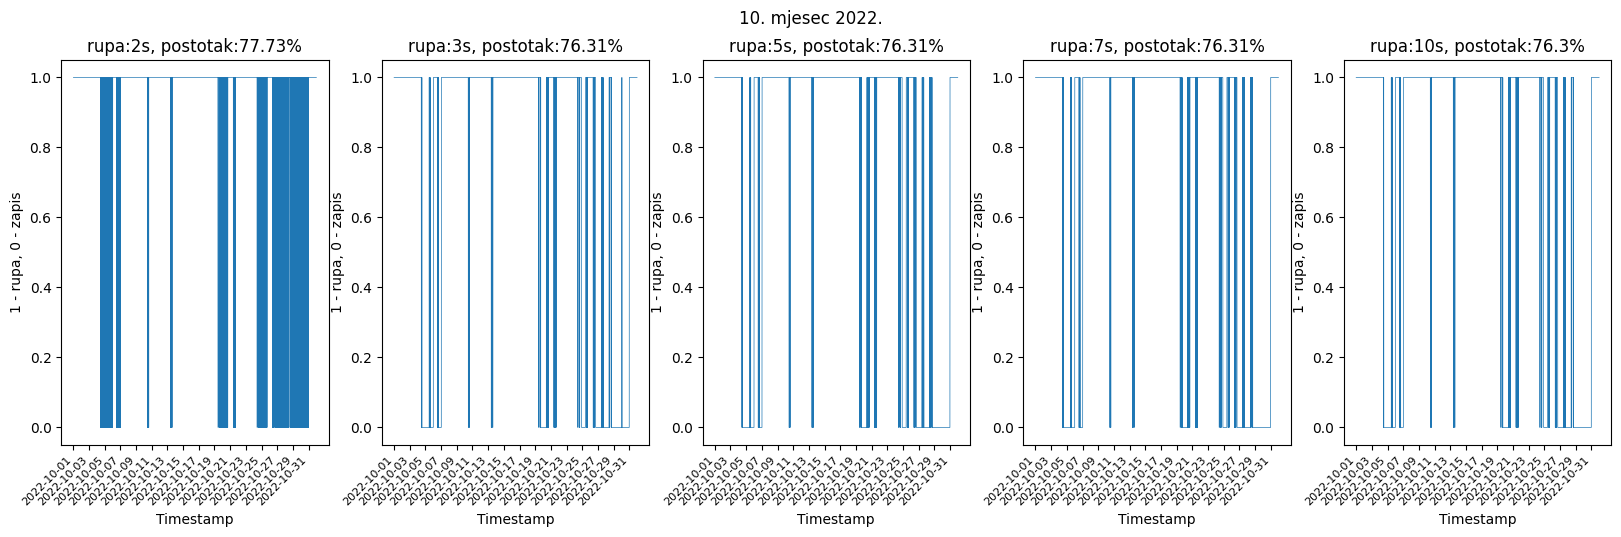

11. mjesec
               start-time            end-time         duration
0     2022-11-01 00:00:58 2022-11-01 00:01:01  0 days 00:00:03
1     2022-11-01 00:02:33 2022-11-01 00:02:36  0 days 00:00:03
2     2022-11-01 00:04:06 2022-11-01 00:04:09  0 days 00:00:03
3     2022-11-01 00:05:33 2022-11-01 00:05:36  0 days 00:00:03
4     2022-11-01 00:07:02 2022-11-01 00:07:05  0 days 00:00:03
...                   ...                 ...              ...
13304 2022-11-15 18:13:23 2022-11-15 18:13:26  0 days 00:00:03
13305 2022-11-15 18:14:14 2022-11-15 18:14:17  0 days 00:00:03
13306 2022-11-15 18:15:43 2022-11-15 18:15:46  0 days 00:00:03
13307 2022-11-15 18:16:22 2022-11-15 18:16:25  0 days 00:00:03
13308 2022-11-15 18:17:15 2022-11-30 23:59:59 15 days 05:42:44

[13309 rows x 3 columns]
Postotak rupa: 55.65 %, rupa: 0 days 00:00:02
            start-time            end-time         duration
0  2022-11-02 09:54:14 2022-11-02 11:30:51  0 days 01:36:37
1  2022-11-02 11:31:34 2022-11-02 11:37:0

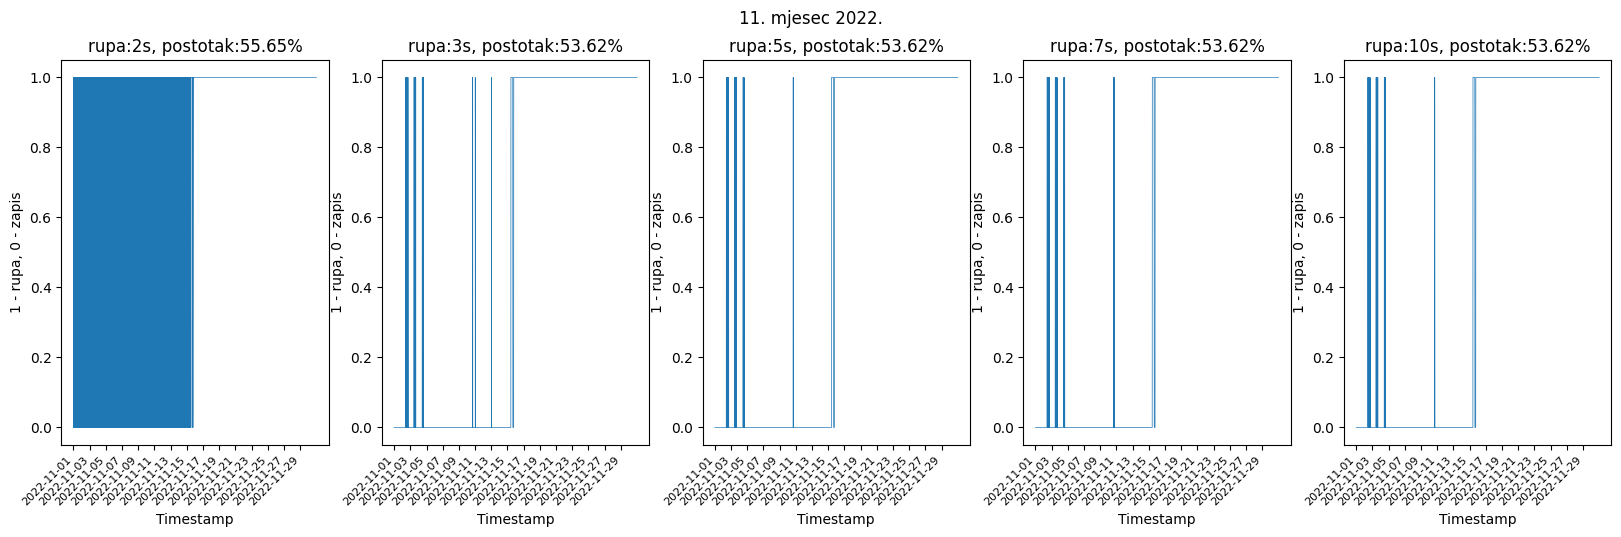

1. mjesec
               start-time            end-time        duration
0     2023-01-01 00:00:25 2023-01-01 00:00:28 0 days 00:00:03
1     2023-01-01 00:01:18 2023-01-01 00:01:21 0 days 00:00:03
2     2023-01-01 00:02:03 2023-01-01 00:02:06 0 days 00:00:03
3     2023-01-01 00:03:06 2023-01-01 00:03:09 0 days 00:00:03
4     2023-01-01 00:03:41 2023-01-01 00:03:44 0 days 00:00:03
...                   ...                 ...             ...
27699 2023-01-30 23:53:50 2023-01-30 23:53:53 0 days 00:00:03
27700 2023-01-30 23:55:21 2023-01-30 23:55:24 0 days 00:00:03
27701 2023-01-30 23:57:02 2023-01-30 23:57:05 0 days 00:00:03
27702 2023-01-30 23:58:51 2023-01-30 23:58:54 0 days 00:00:03
27703 2023-01-31 00:00:00 2023-01-31 23:59:59 0 days 23:59:59

[27704 rows x 3 columns]
Postotak rupa: 38.86 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-01-11 10:59:35 2023-01-17 09:35:18 5 days 22:35:43
1  2023-01-17 09:35:37 2023-01-17 11:46:19 0 days 02:10:

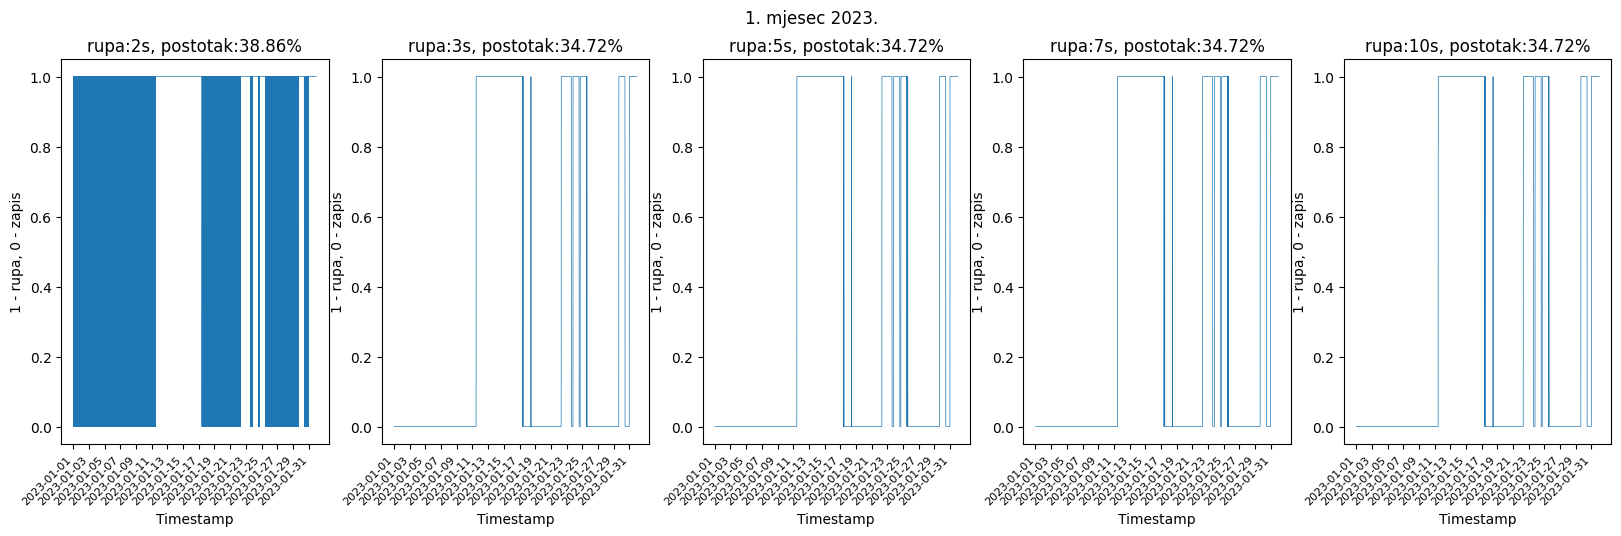

2. mjesec
               start-time            end-time        duration
0     2023-02-01 00:01:30 2023-02-01 00:01:33 0 days 00:00:03
1     2023-02-01 00:03:17 2023-02-01 00:03:20 0 days 00:00:03
2     2023-02-01 00:05:30 2023-02-01 00:05:33 0 days 00:00:03
3     2023-02-01 00:07:17 2023-02-01 00:07:20 0 days 00:00:03
4     2023-02-01 00:09:14 2023-02-01 00:09:17 0 days 00:00:03
...                   ...                 ...             ...
19548 2023-02-21 09:14:32 2023-02-21 09:14:35 0 days 00:00:03
19549 2023-02-21 09:16:53 2023-02-21 09:16:56 0 days 00:00:03
19550 2023-02-21 09:19:16 2023-02-21 09:19:19 0 days 00:00:03
19551 2023-02-21 09:21:25 2023-02-21 09:21:28 0 days 00:00:03
19552 2023-02-21 09:22:18 2023-02-28 23:59:59 7 days 14:37:41

[19553 rows x 3 columns]
Postotak rupa: 32.56 %, rupa: 0 days 00:00:02
           start-time            end-time        duration
0 2023-02-02 12:39:30 2023-02-02 17:08:40 0 days 04:29:10
1 2023-02-07 10:34:43 2023-02-07 16:54:37 0 days 06:19:54


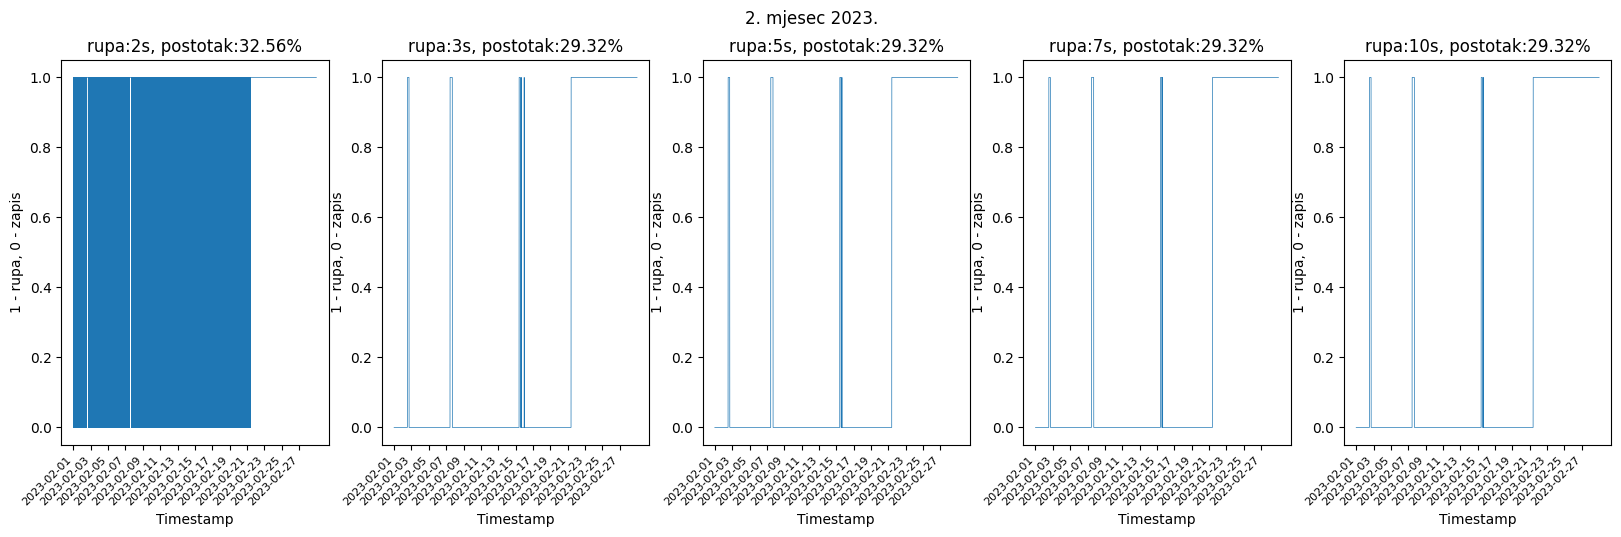

3. mjesec
               start-time            end-time        duration
0     2023-03-01 00:00:01 2023-03-01 00:00:04 0 days 00:00:03
1     2023-03-01 00:02:02 2023-03-01 00:02:05 0 days 00:00:03
2     2023-03-01 00:03:27 2023-03-01 00:03:30 0 days 00:00:03
3     2023-03-01 00:05:48 2023-03-01 00:05:51 0 days 00:00:03
4     2023-03-01 00:07:39 2023-03-01 00:07:42 0 days 00:00:03
...                   ...                 ...             ...
18301 2023-03-30 16:15:50 2023-03-30 16:15:53 0 days 00:00:03
18302 2023-03-30 16:17:47 2023-03-30 16:17:50 0 days 00:00:03
18303 2023-03-30 16:18:52 2023-03-30 16:18:55 0 days 00:00:03
18304 2023-03-30 16:19:43 2023-03-30 16:19:46 0 days 00:00:03
18305 2023-03-30 16:20:32 2023-03-31 23:59:59 1 days 07:39:27

[18306 rows x 3 columns]
Postotak rupa: 35.73 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-03-08 11:40:02 2023-03-08 15:30:07 0 days 03:50:05
1  2023-03-14 15:53:21 2023-03-20 09:29:27 5 days 17:36:

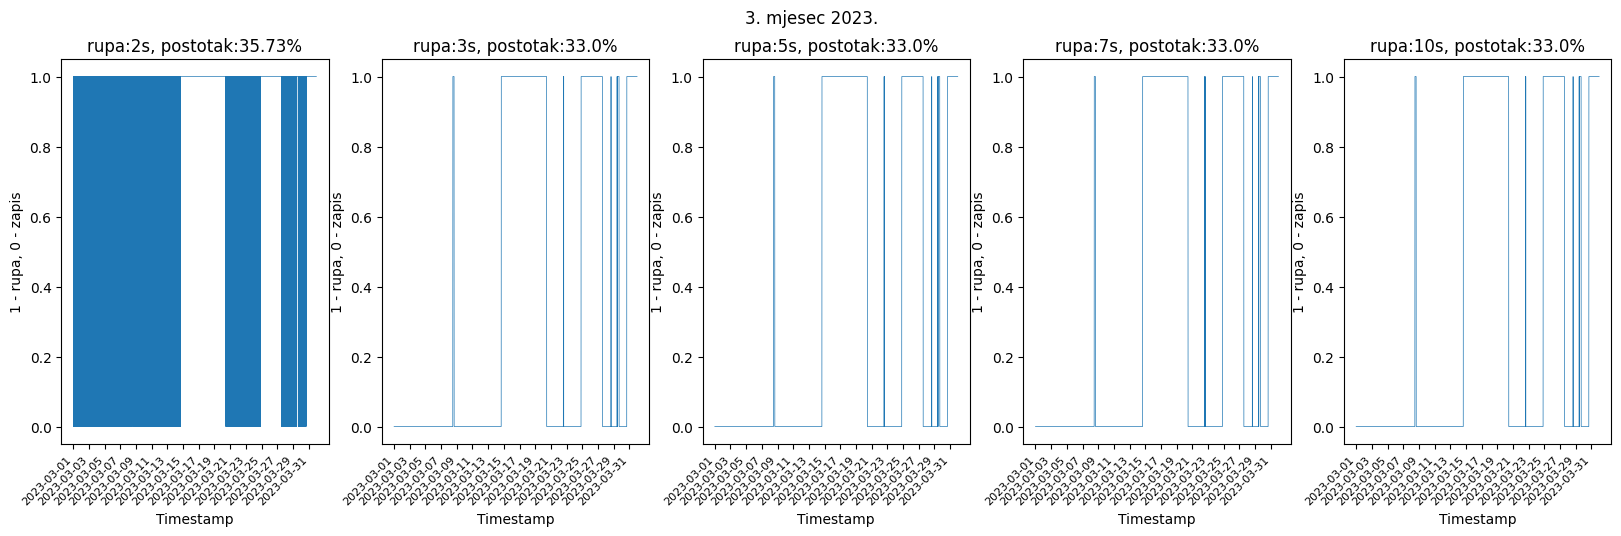

4. mjesec
               start-time            end-time        duration
0     2023-04-01 00:00:01 2023-04-01 00:00:04 0 days 00:00:03
1     2023-04-01 00:02:12 2023-04-01 00:02:15 0 days 00:00:03
2     2023-04-01 00:04:17 2023-04-01 00:04:20 0 days 00:00:03
3     2023-04-01 00:06:12 2023-04-01 00:06:15 0 days 00:00:03
4     2023-04-01 00:08:51 2023-04-01 00:08:54 0 days 00:00:03
...                   ...                 ...             ...
74563 2023-04-29 23:58:16 2023-04-29 23:58:19 0 days 00:00:03
74564 2023-04-29 23:58:45 2023-04-29 23:58:48 0 days 00:00:03
74565 2023-04-29 23:59:16 2023-04-29 23:59:19 0 days 00:00:03
74566 2023-04-29 23:59:45 2023-04-29 23:59:48 0 days 00:00:03
74567 2023-04-30 00:00:00 2023-04-30 23:59:59 0 days 23:59:59

[74568 rows x 3 columns]
Postotak rupa: 27.91 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-04-01 08:24:50 2023-04-03 11:09:03 2 days 02:44:13
1  2023-04-03 11:18:05 2023-04-03 11:18:09 0 days 00:00:

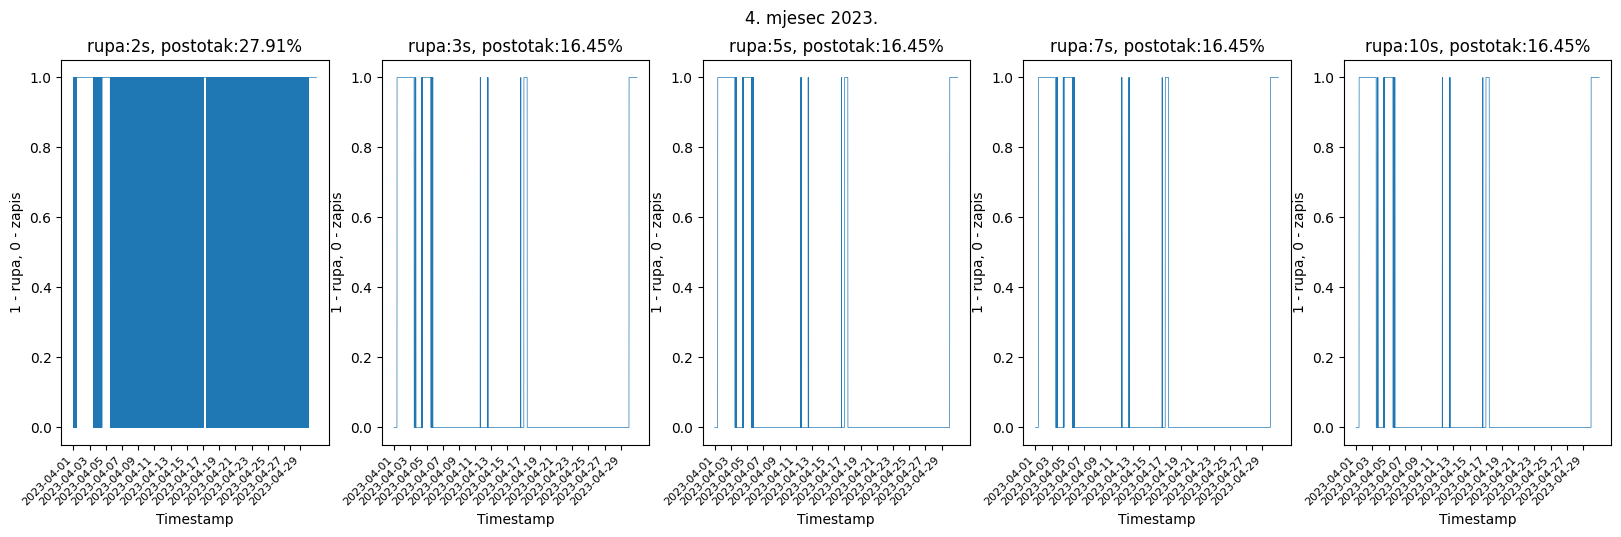

5. mjesec
               start-time            end-time        duration
0     2023-05-01 00:00:23 2023-05-01 00:00:26 0 days 00:00:03
1     2023-05-01 00:00:54 2023-05-01 00:00:57 0 days 00:00:03
2     2023-05-01 00:01:21 2023-05-01 00:01:24 0 days 00:00:03
3     2023-05-01 00:01:52 2023-05-01 00:01:55 0 days 00:00:03
4     2023-05-01 00:02:19 2023-05-01 00:02:22 0 days 00:00:03
...                   ...                 ...             ...
93297 2023-05-30 23:58:15 2023-05-30 23:58:18 0 days 00:00:03
93298 2023-05-30 23:58:42 2023-05-30 23:58:45 0 days 00:00:03
93299 2023-05-30 23:59:07 2023-05-30 23:59:10 0 days 00:00:03
93300 2023-05-30 23:59:34 2023-05-30 23:59:37 0 days 00:00:03
93301 2023-05-30 23:59:59 2023-05-31 23:59:59 1 days 00:00:00

[93302 rows x 3 columns]
Postotak rupa: 17.16 %, rupa: 0 days 00:00:02
           start-time            end-time        duration
0 2023-05-19 14:14:57 2023-05-19 14:15:07 0 days 00:00:10
1 2023-05-30 23:59:59 2023-05-31 23:59:59 1 days 00:00:00


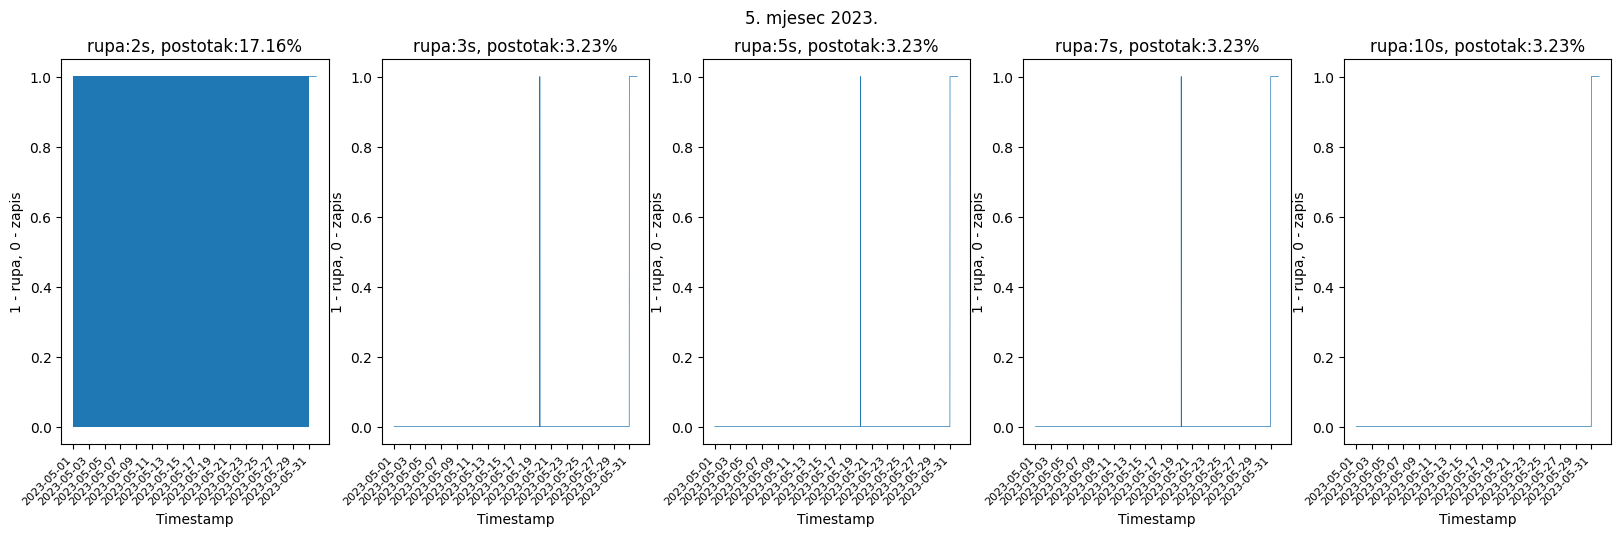

6. mjesec
               start-time            end-time        duration
0     2023-06-01 00:00:14 2023-06-01 00:00:17 0 days 00:00:03
1     2023-06-01 00:00:39 2023-06-01 00:00:42 0 days 00:00:03
2     2023-06-01 00:01:08 2023-06-01 00:01:11 0 days 00:00:03
3     2023-06-01 00:01:33 2023-06-01 00:01:36 0 days 00:00:03
4     2023-06-01 00:02:00 2023-06-01 00:02:03 0 days 00:00:03
...                   ...                 ...             ...
87824 2023-06-29 23:58:18 2023-06-29 23:58:21 0 days 00:00:03
87825 2023-06-29 23:58:41 2023-06-29 23:58:44 0 days 00:00:03
87826 2023-06-29 23:59:08 2023-06-29 23:59:11 0 days 00:00:03
87827 2023-06-29 23:59:35 2023-06-29 23:59:38 0 days 00:00:03
87828 2023-06-30 00:00:00 2023-06-30 23:59:59 0 days 23:59:59

[87829 rows x 3 columns]
Postotak rupa: 23.86 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-06-01 12:56:43 2023-06-01 12:56:47 0 days 00:00:04
1  2023-06-01 12:57:31 2023-06-01 12:57:35 0 days 00:00:

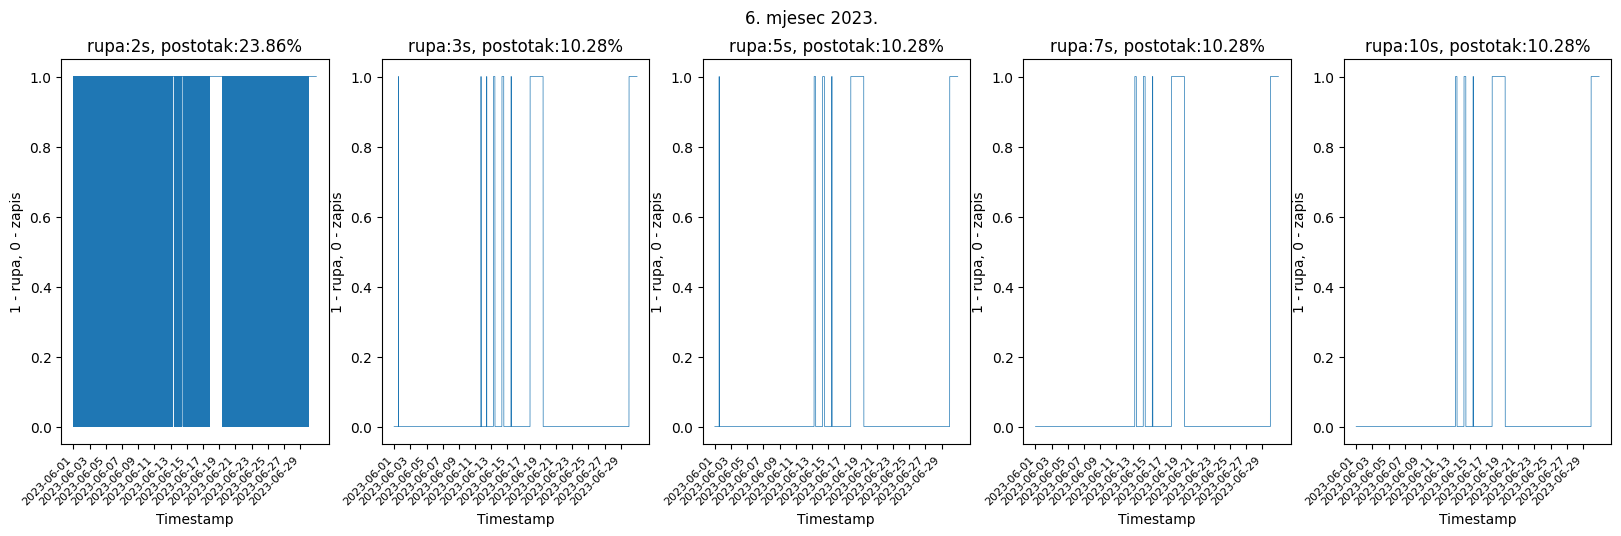

7. mjesec
               start-time            end-time        duration
0     2023-07-01 00:00:01 2023-07-01 00:00:04 0 days 00:00:03
1     2023-07-01 00:00:26 2023-07-01 00:00:29 0 days 00:00:03
2     2023-07-01 00:00:49 2023-07-01 00:00:52 0 days 00:00:03
3     2023-07-01 00:01:22 2023-07-01 00:01:25 0 days 00:00:03
4     2023-07-01 00:01:45 2023-07-01 00:01:48 0 days 00:00:03
...                   ...                 ...             ...
91293 2023-07-30 23:58:17 2023-07-30 23:58:20 0 days 00:00:03
91294 2023-07-30 23:58:44 2023-07-30 23:58:47 0 days 00:00:03
91295 2023-07-30 23:59:09 2023-07-30 23:59:12 0 days 00:00:03
91296 2023-07-30 23:59:36 2023-07-30 23:59:39 0 days 00:00:03
91297 2023-07-30 23:59:59 2023-07-31 23:59:59 1 days 00:00:00

[91298 rows x 3 columns]
Postotak rupa: 25.35 %, rupa: 0 days 00:00:02
           start-time            end-time        duration
0 2023-07-06 09:36:06 2023-07-06 09:36:10 0 days 00:00:04
1 2023-07-06 09:36:16 2023-07-06 09:36:21 0 days 00:00:05


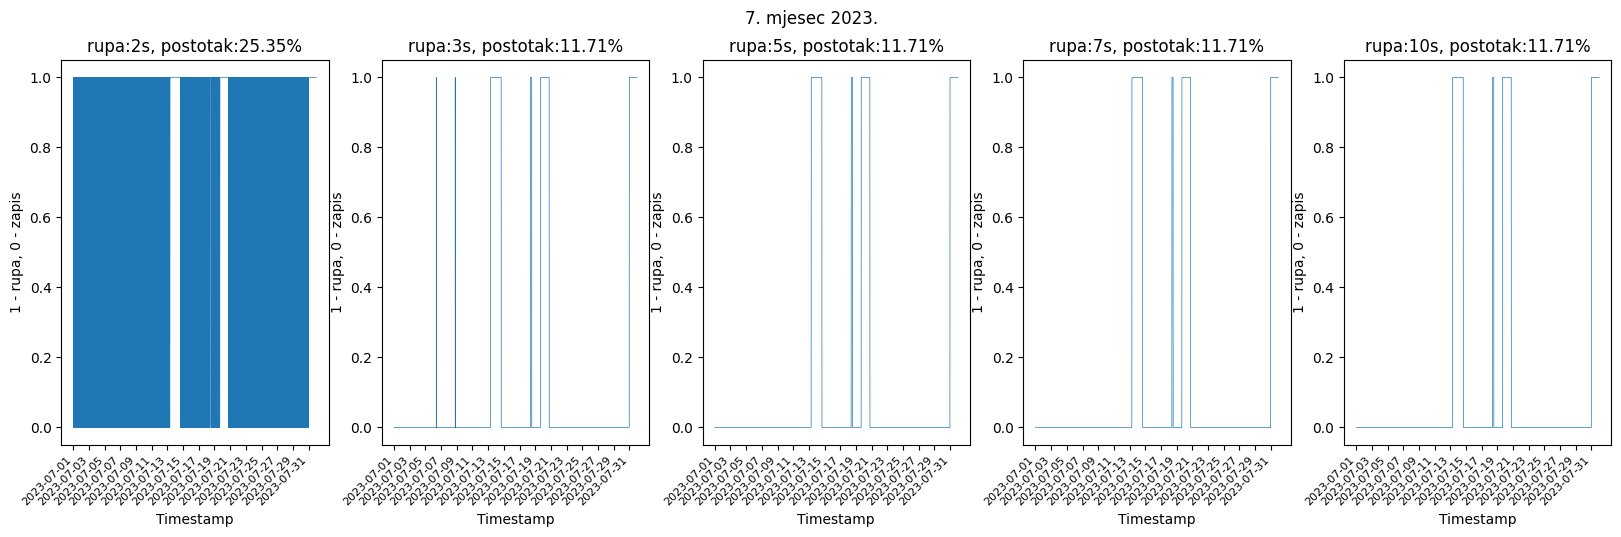

8. mjesec
               start-time            end-time        duration
0     2023-08-01 00:00:02 2023-08-01 00:00:05 0 days 00:00:03
1     2023-08-01 00:00:27 2023-08-01 00:00:30 0 days 00:00:03
2     2023-08-01 00:00:54 2023-08-01 00:00:57 0 days 00:00:03
3     2023-08-01 00:01:19 2023-08-01 00:01:22 0 days 00:00:03
4     2023-08-01 00:01:44 2023-08-01 00:01:47 0 days 00:00:03
...                   ...                 ...             ...
83366 2023-08-30 23:58:06 2023-08-30 23:58:09 0 days 00:00:03
83367 2023-08-30 23:58:41 2023-08-30 23:58:44 0 days 00:00:03
83368 2023-08-30 23:59:14 2023-08-30 23:59:17 0 days 00:00:03
83369 2023-08-30 23:59:49 2023-08-30 23:59:52 0 days 00:00:03
83370 2023-08-31 00:00:00 2023-08-31 23:59:59 0 days 23:59:59

[83371 rows x 3 columns]
Postotak rupa: 27.12 %, rupa: 0 days 00:00:02
           start-time            end-time        duration
0 2023-08-02 11:51:01 2023-08-02 11:51:05 0 days 00:00:04
1 2023-08-05 05:13:02 2023-08-08 18:08:52 3 days 12:55:50


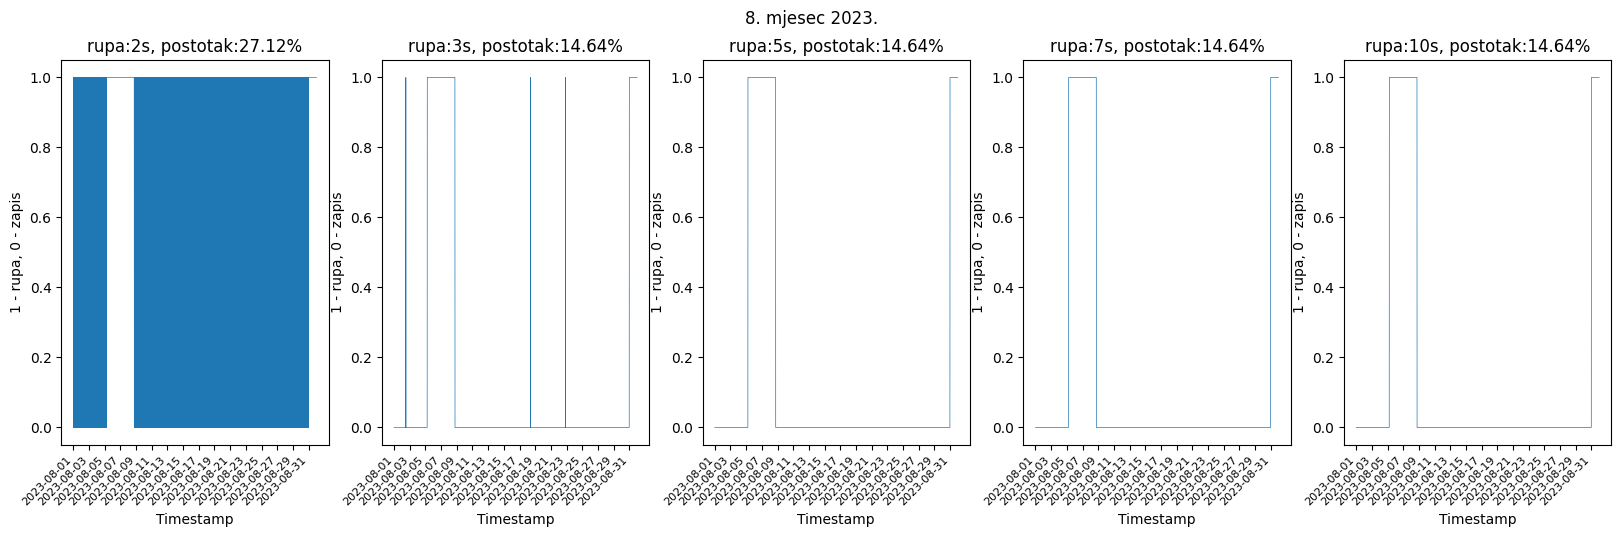

9. mjesec
               start-time            end-time        duration
0     2023-09-01 00:00:05 2023-09-01 00:00:08 0 days 00:00:03
1     2023-09-01 00:00:36 2023-09-01 00:00:39 0 days 00:00:03
2     2023-09-01 00:01:09 2023-09-01 00:01:12 0 days 00:00:03
3     2023-09-01 00:01:40 2023-09-01 00:01:43 0 days 00:00:03
4     2023-09-01 00:02:13 2023-09-01 00:02:16 0 days 00:00:03
...                   ...                 ...             ...
63554 2023-09-29 23:58:20 2023-09-29 23:58:23 0 days 00:00:03
63555 2023-09-29 23:58:45 2023-09-29 23:58:48 0 days 00:00:03
63556 2023-09-29 23:59:10 2023-09-29 23:59:13 0 days 00:00:03
63557 2023-09-29 23:59:35 2023-09-29 23:59:38 0 days 00:00:03
63558 2023-09-29 23:59:58 2023-09-30 23:59:59 1 days 00:00:01

[63559 rows x 3 columns]
Postotak rupa: 35.69 %, rupa: 0 days 00:00:02
            start-time            end-time        duration
0  2023-09-01 16:24:32 2023-09-01 16:24:45 0 days 00:00:13
1  2023-09-04 12:48:14 2023-09-04 12:48:22 0 days 00:00:

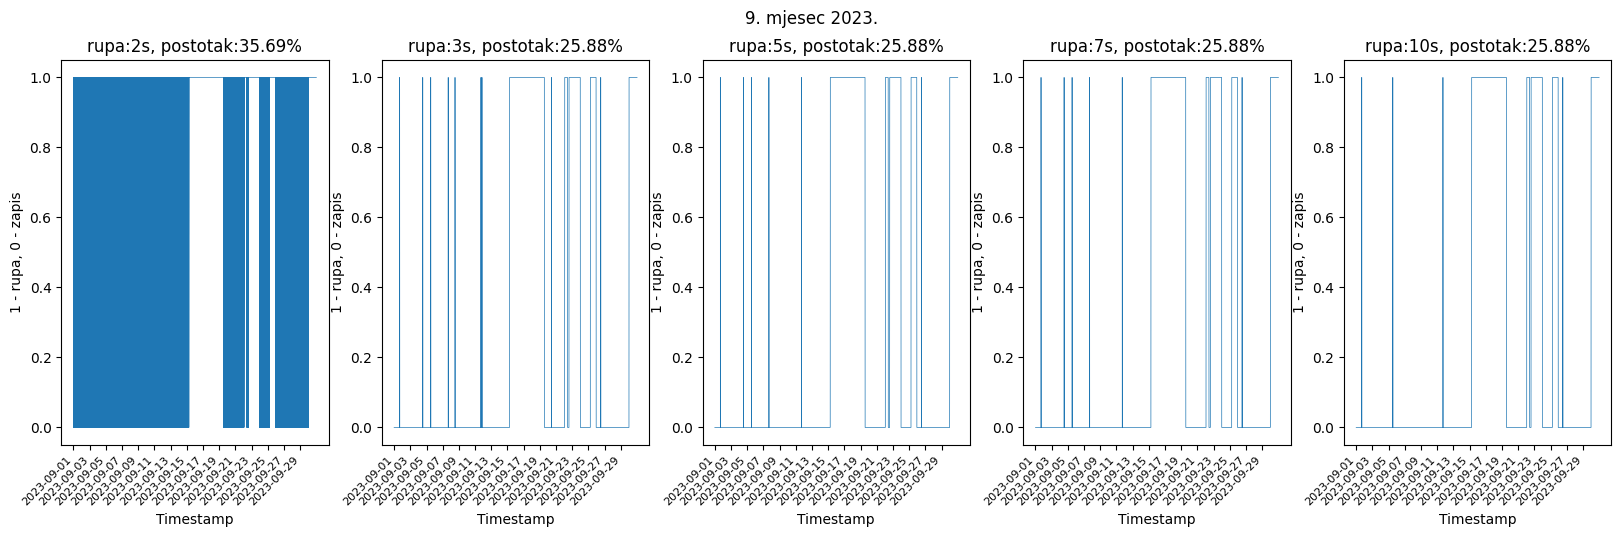

10. mjesec
               start-time            end-time        duration
0     2023-10-01 00:00:00 2023-10-02 10:04:26 1 days 10:04:26
1     2023-10-02 10:04:40 2023-10-02 10:04:43 0 days 00:00:03
2     2023-10-02 10:05:07 2023-10-02 10:05:10 0 days 00:00:03
3     2023-10-02 10:05:34 2023-10-02 10:05:37 0 days 00:00:03
4     2023-10-02 10:06:01 2023-10-02 10:06:04 0 days 00:00:03
...                   ...                 ...             ...
92202 2023-10-30 23:58:27 2023-10-30 23:58:30 0 days 00:00:03
92203 2023-10-30 23:58:52 2023-10-30 23:58:55 0 days 00:00:03
92204 2023-10-30 23:59:15 2023-10-30 23:59:18 0 days 00:00:03
92205 2023-10-30 23:59:42 2023-10-30 23:59:45 0 days 00:00:03
92206 2023-10-30 23:59:59 2023-10-31 23:59:59 1 days 00:00:00

[92207 rows x 3 columns]
Postotak rupa: 27.24 %, rupa: 0 days 00:00:02
             start-time            end-time        duration
0   2023-10-01 00:00:00 2023-10-02 10:04:26 1 days 10:04:26
1   2023-10-02 11:34:46 2023-10-02 11:34:50 0 days 00

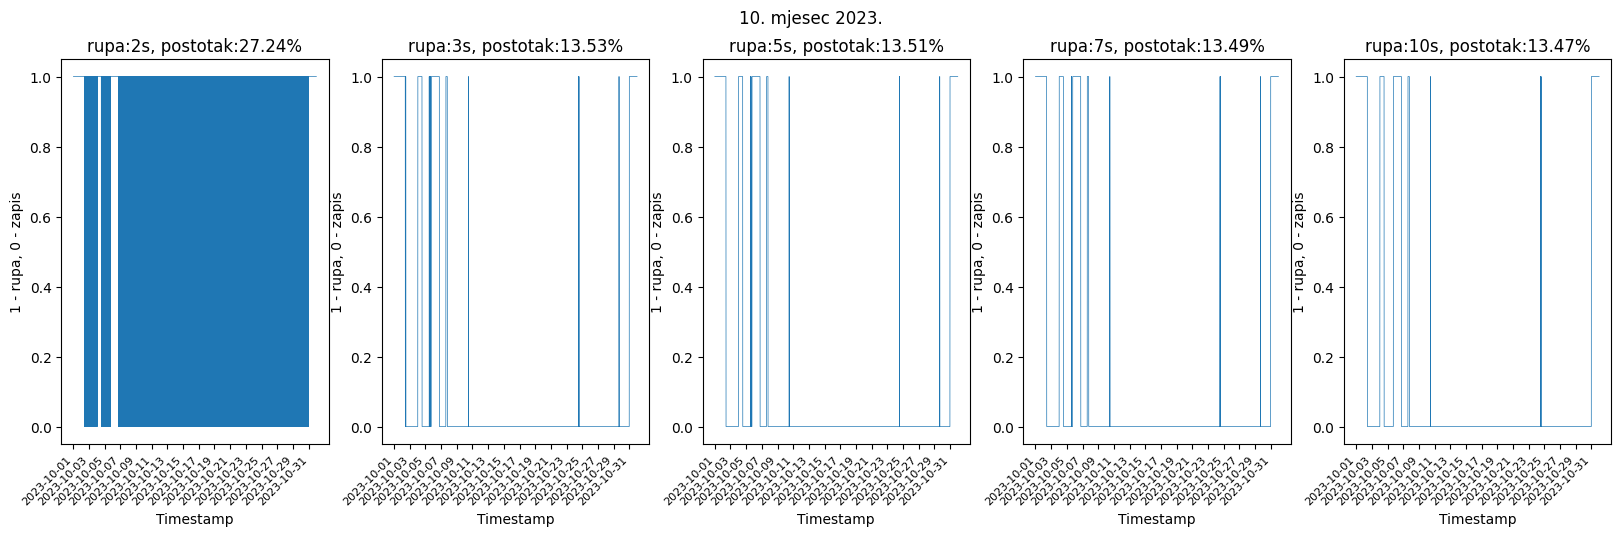

In [263]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05'),pd.to_timedelta('00:00:07'),pd.to_timedelta('00:00:10')]
for i in range (4,13):
    make_graph(i,2022,steps, True)
for i in range(1,12):
    make_graph(i,2023,steps, True)
